In [5]:
from searchtweets import ResultStream, gen_rule_payload, load_credentials, collect_results

# general imports
import numpy as np
import pandas as pd
#import tweepy
from textblob import TextBlob
import re
import time
import datetime

# plotting and visualization
import matplotlib
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [10]:
S2_Date = pd.read_csv('tweets_2018-08-01_2018-08-15_Date.csv', names=['Date'], parse_dates=['Date'])
S2_Tweets = pd.read_csv('tweets_2018-08-01_2018-08-15_Tweets.csv', names=['Tweets'])
S2 = pd.concat([S2_Tweets, S2_Date], axis=1)

In [11]:
S2.head()

,Tweets,Date
0,Haha @Eminem dropped that new album and name d...,2018-08-31 23:59:57
1,RT @coingecko: Have you tried comparing coins ...,2018-08-31 23:59:51
2,RT @cryptocomicon: Chris DeRose spends an 86 m...,2018-08-31 23:59:47
3,RT @santisiri: un partido político que opera s...,2018-08-31 23:59:46
4,RT @BitcoinDood: DNA: The Safest Way to Store ...,2018-08-31 23:59:45


In [12]:
def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    
    textblob already has a trained analyser to work 
    with different machine learning models on 
    natural language processing.
    
    Might want to train our own model
    '''
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1
    

def sentiment_analysis(S2):
    # We create a column with the result of the analysis:
    S2['SA'] = np.array([ analize_sentiment(tweet) for tweet in S2['Tweets'] ])
    
    # We construct lists with classified tweets:
    pos_tweets = [ tweet for index, tweet in enumerate(S2['Tweets']) if S2['SA'][index] > 0]
    neu_tweets = [ tweet for index, tweet in enumerate(S2['Tweets']) if S2['SA'][index] == 0]
    neg_tweets = [ tweet for index, tweet in enumerate(S2['Tweets']) if S2['SA'][index] < 0]

    # We print percentages:
    print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(S2['Tweets'])))
    print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(S2['Tweets'])))
    print("Percentage de negative tweets: {}%".format(len(neg_tweets)*100/len(S2['Tweets'])))

In [13]:
sentiment_analysis(S2)

Percentage of positive tweets: 37.525%
Percentage of neutral tweets: 52.1%
Percentage de negative tweets: 10.375%


In [14]:
S2['rounded_day'] = S2['Date'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day))
S2['rounded_hour'] = S2['Date'].dt.round('H')

In [15]:
S2.head()

,Tweets,Date,SA,rounded_day,rounded_hour
0,Haha @Eminem dropped that new album and name d...,2018-08-31 23:59:57,1,2018-08-31,2018-09-01
1,RT @coingecko: Have you tried comparing coins ...,2018-08-31 23:59:51,0,2018-08-31,2018-09-01
2,RT @cryptocomicon: Chris DeRose spends an 86 m...,2018-08-31 23:59:47,0,2018-08-31,2018-09-01
3,RT @santisiri: un partido político que opera s...,2018-08-31 23:59:46,0,2018-08-31,2018-09-01
4,RT @BitcoinDood: DNA: The Safest Way to Store ...,2018-08-31 23:59:45,0,2018-08-31,2018-09-01


In [16]:
S3_A = S2.groupby(['rounded_hour']).agg('count').reset_index()
S3 = S2.groupby(['rounded_hour', 'SA']).agg('count').reset_index()
S3 = S3.assign(count = S3['Tweets']).loc[:,['rounded_hour', 'SA', 'count']]
S3_pivot = S3.pivot(index = 'rounded_hour', columns='SA', values='count')

In [17]:
S3.head()

,rounded_hour,SA,count
0,2018-09-01 00:00:00,-1,8
1,2018-09-01 00:00:00,0,61
2,2018-09-01 00:00:00,1,31
3,2018-09-01 03:00:00,-1,6
4,2018-09-01 03:00:00,0,54


In [18]:
S3_pivot.head()

SA,-1,0,1
rounded_hour,,,
2018-09-01 00:00:00,8,61,31
2018-09-01 03:00:00,6,54,40
2018-09-01 06:00:00,5,50,45
2018-09-01 09:00:00,5,57,38
2018-09-01 12:00:00,7,49,44


In [21]:
'''cmaps = [('Perceptually Uniform Sequential', [
            'viridis', 'plasma', 'inferno', 'magma']),
         ('Sequential', [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
         ('Sequential (2)', [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']),
         ('Diverging', [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
         ('Qualitative', [
            'Pastel1', 'Pastel2', 'Paired', 'Accent',
            'Dark2', 'Set1', 'Set2', 'Set3',
            'tab10', 'tab20', 'tab20b', 'tab20c']),
         ('Miscellaneous', [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])]
'''

def plot_stacked_bar(df, x, y, nrows=1, ncols=1):
    
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, dpi=1200)
    #fig, ax = plt.subplots()
    
    #ax.plot(df[x], df[y], '.')
    df.plot.bar(stacked=True, ax=ax, colormap='Spectral')
    
    # Make most of the ticklabels empty so the labels don't get too crowded
    ticklabels = ['']*len(df.index)
    # Every 5th ticklable shows the month and day
    ticklabels[::8] = [item.strftime('%m.%d') for item in df.index[::8]]
    # Every 12th ticklabel includes the year
    #ticklabels[::12] = [item.strftime('%b %d\n%Y') for item in df.index[::12]]
    plt.style.use('ggplot')
    ax.legend(loc=0)
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
    plt.gcf().autofmt_xdate()
    
    #fig.savefig('stacked_bar_chart_SA.png')
    #plt.close()
    plt.show()

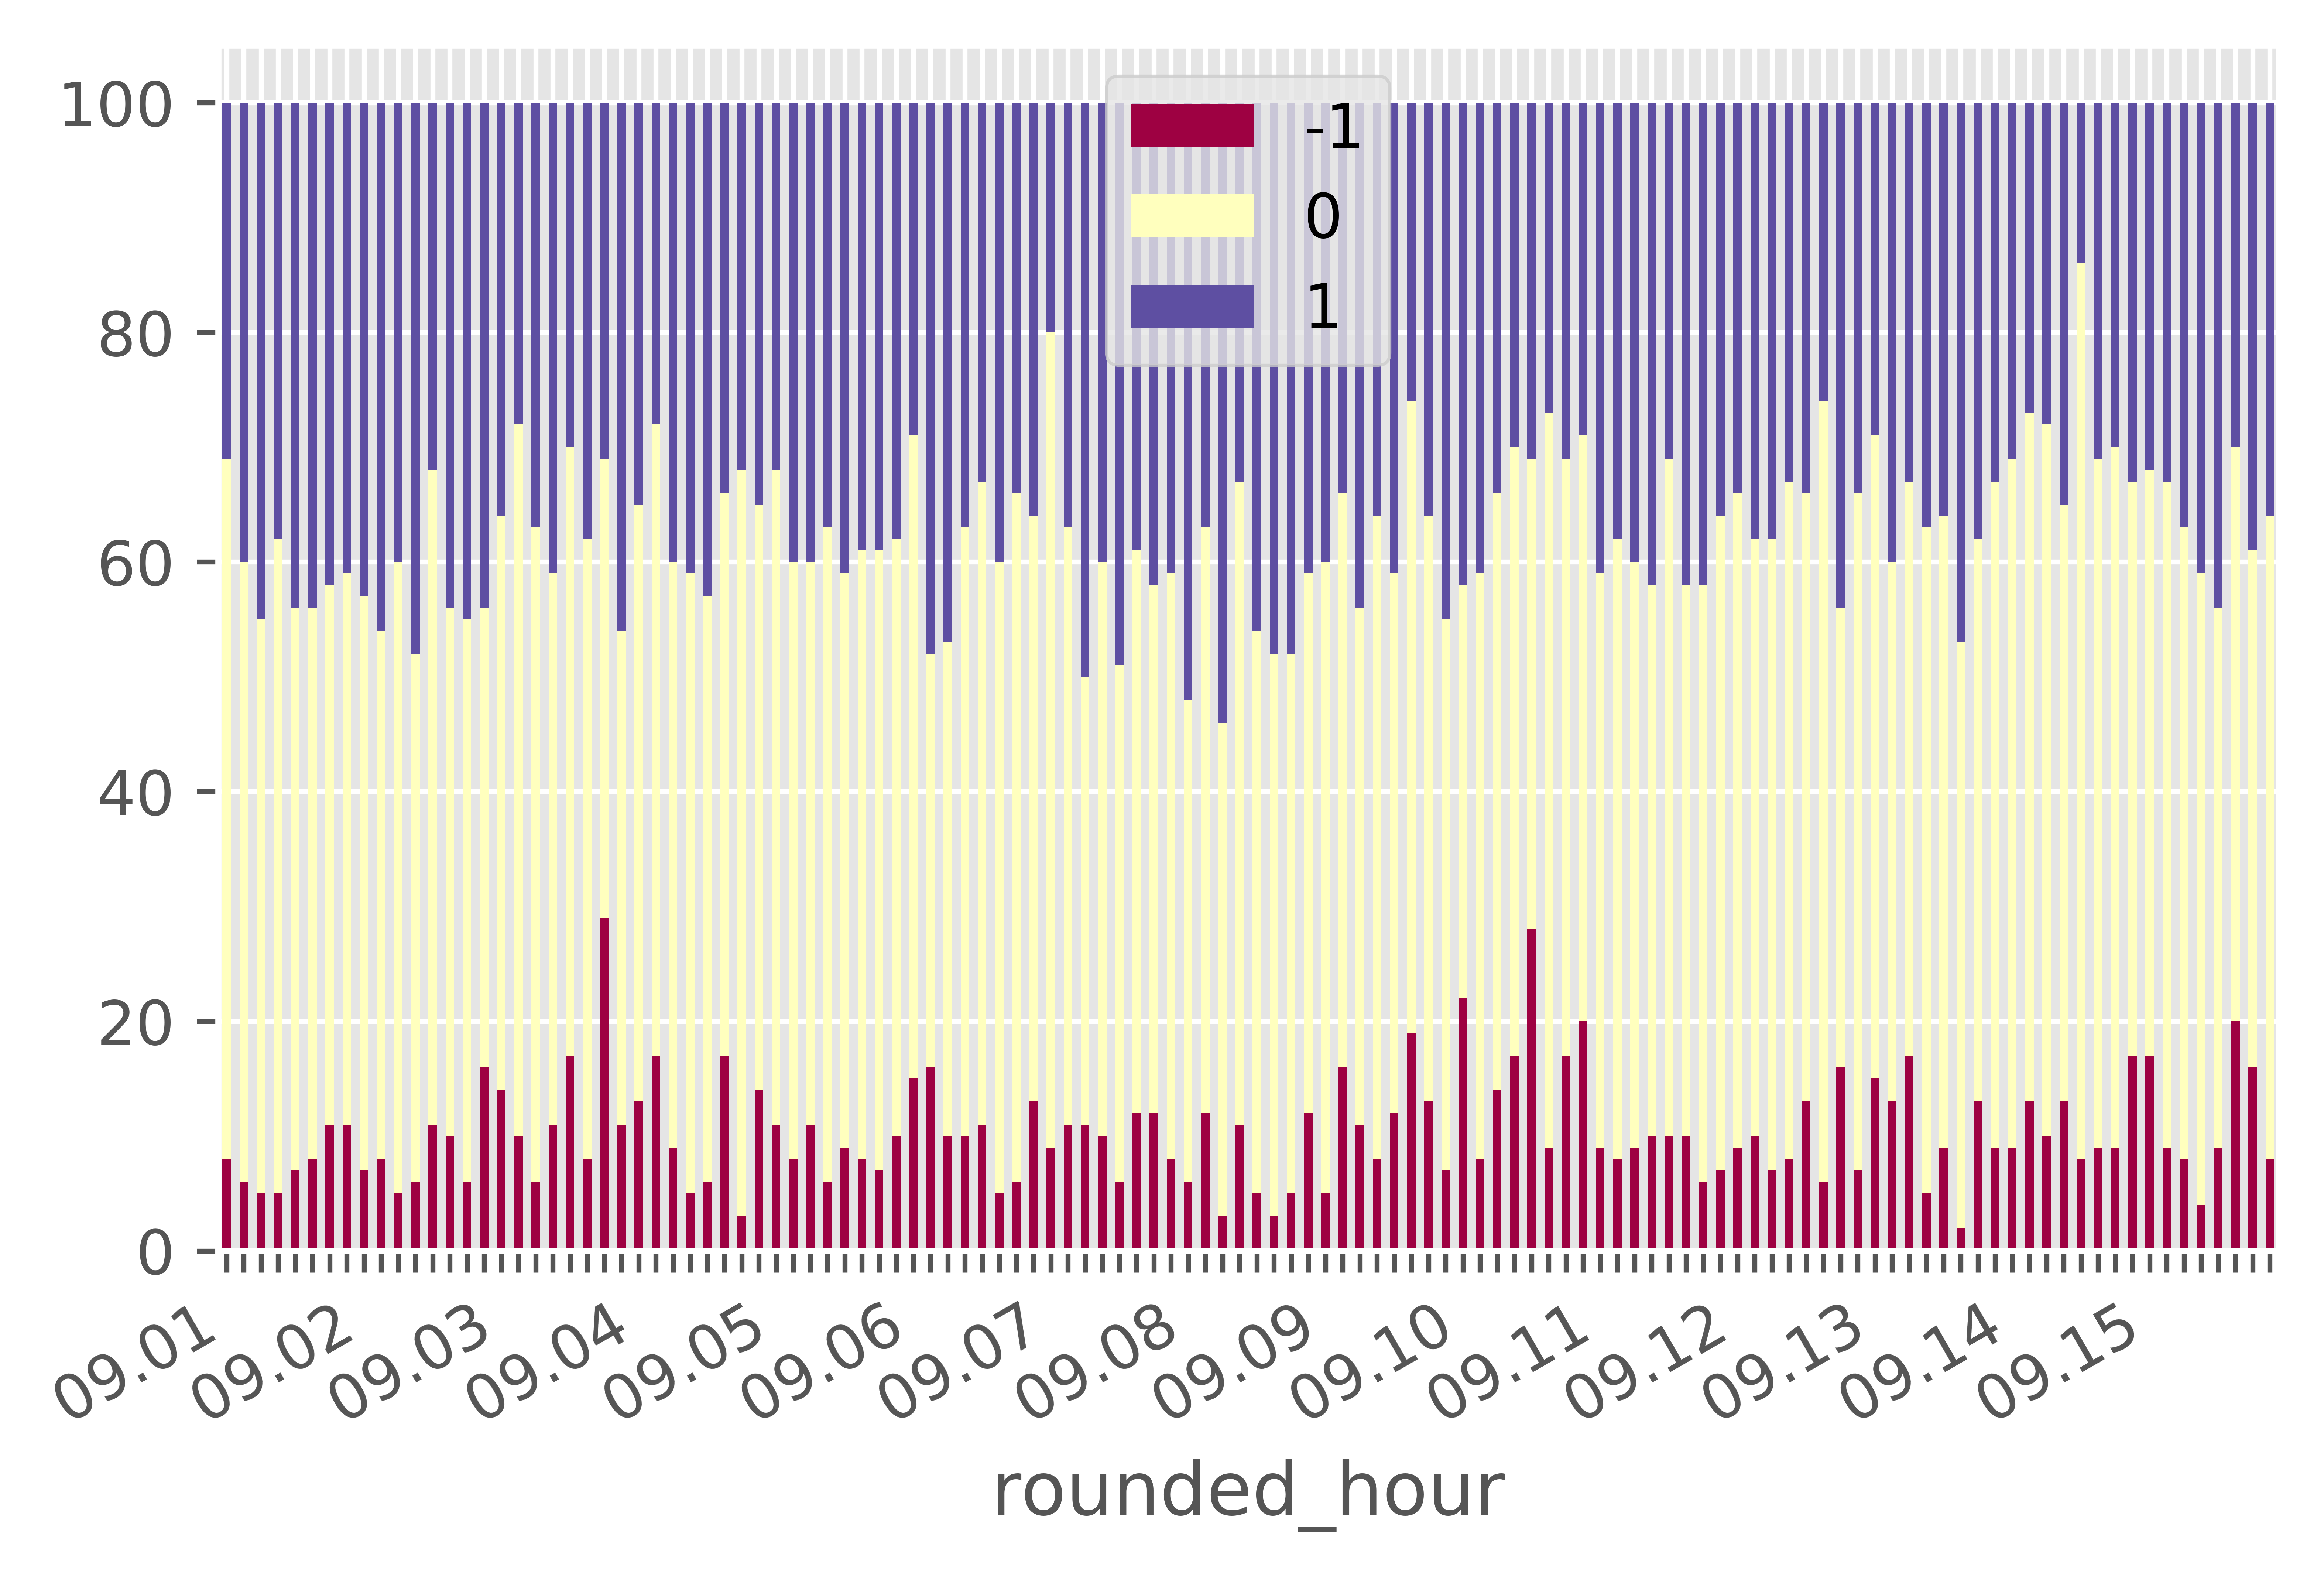

In [22]:
plot_stacked_bar(S3_pivot, 'rounded_hour', 'SA')